In [40]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

# Model Creation Imorts
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201

#Model Learning and
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

In [2]:
image_path=r"C:\Users\Lenovo\OneDrive\Documents\Data set\Image Caption\Images"
data=pd.read_csv(r"C:\Users\Lenovo\OneDrive\Documents\Data set\Image Caption\captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [12]:
def readImage(path,img_size=325): 
    img=load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img=img_to_array(img) 
    img = img/255.
    
    return img

def display_image(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(30,30))

    for n in range(15):
        plt.subplot(5, 5, n+1)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)

        image = readImage(
           rf"C:\Users\Lenovo\OneDrive\Documents\Data set\Image Caption\Images\{temp_df.image[n]}"

        )

        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[n], 20)))
        plt.axis("off")


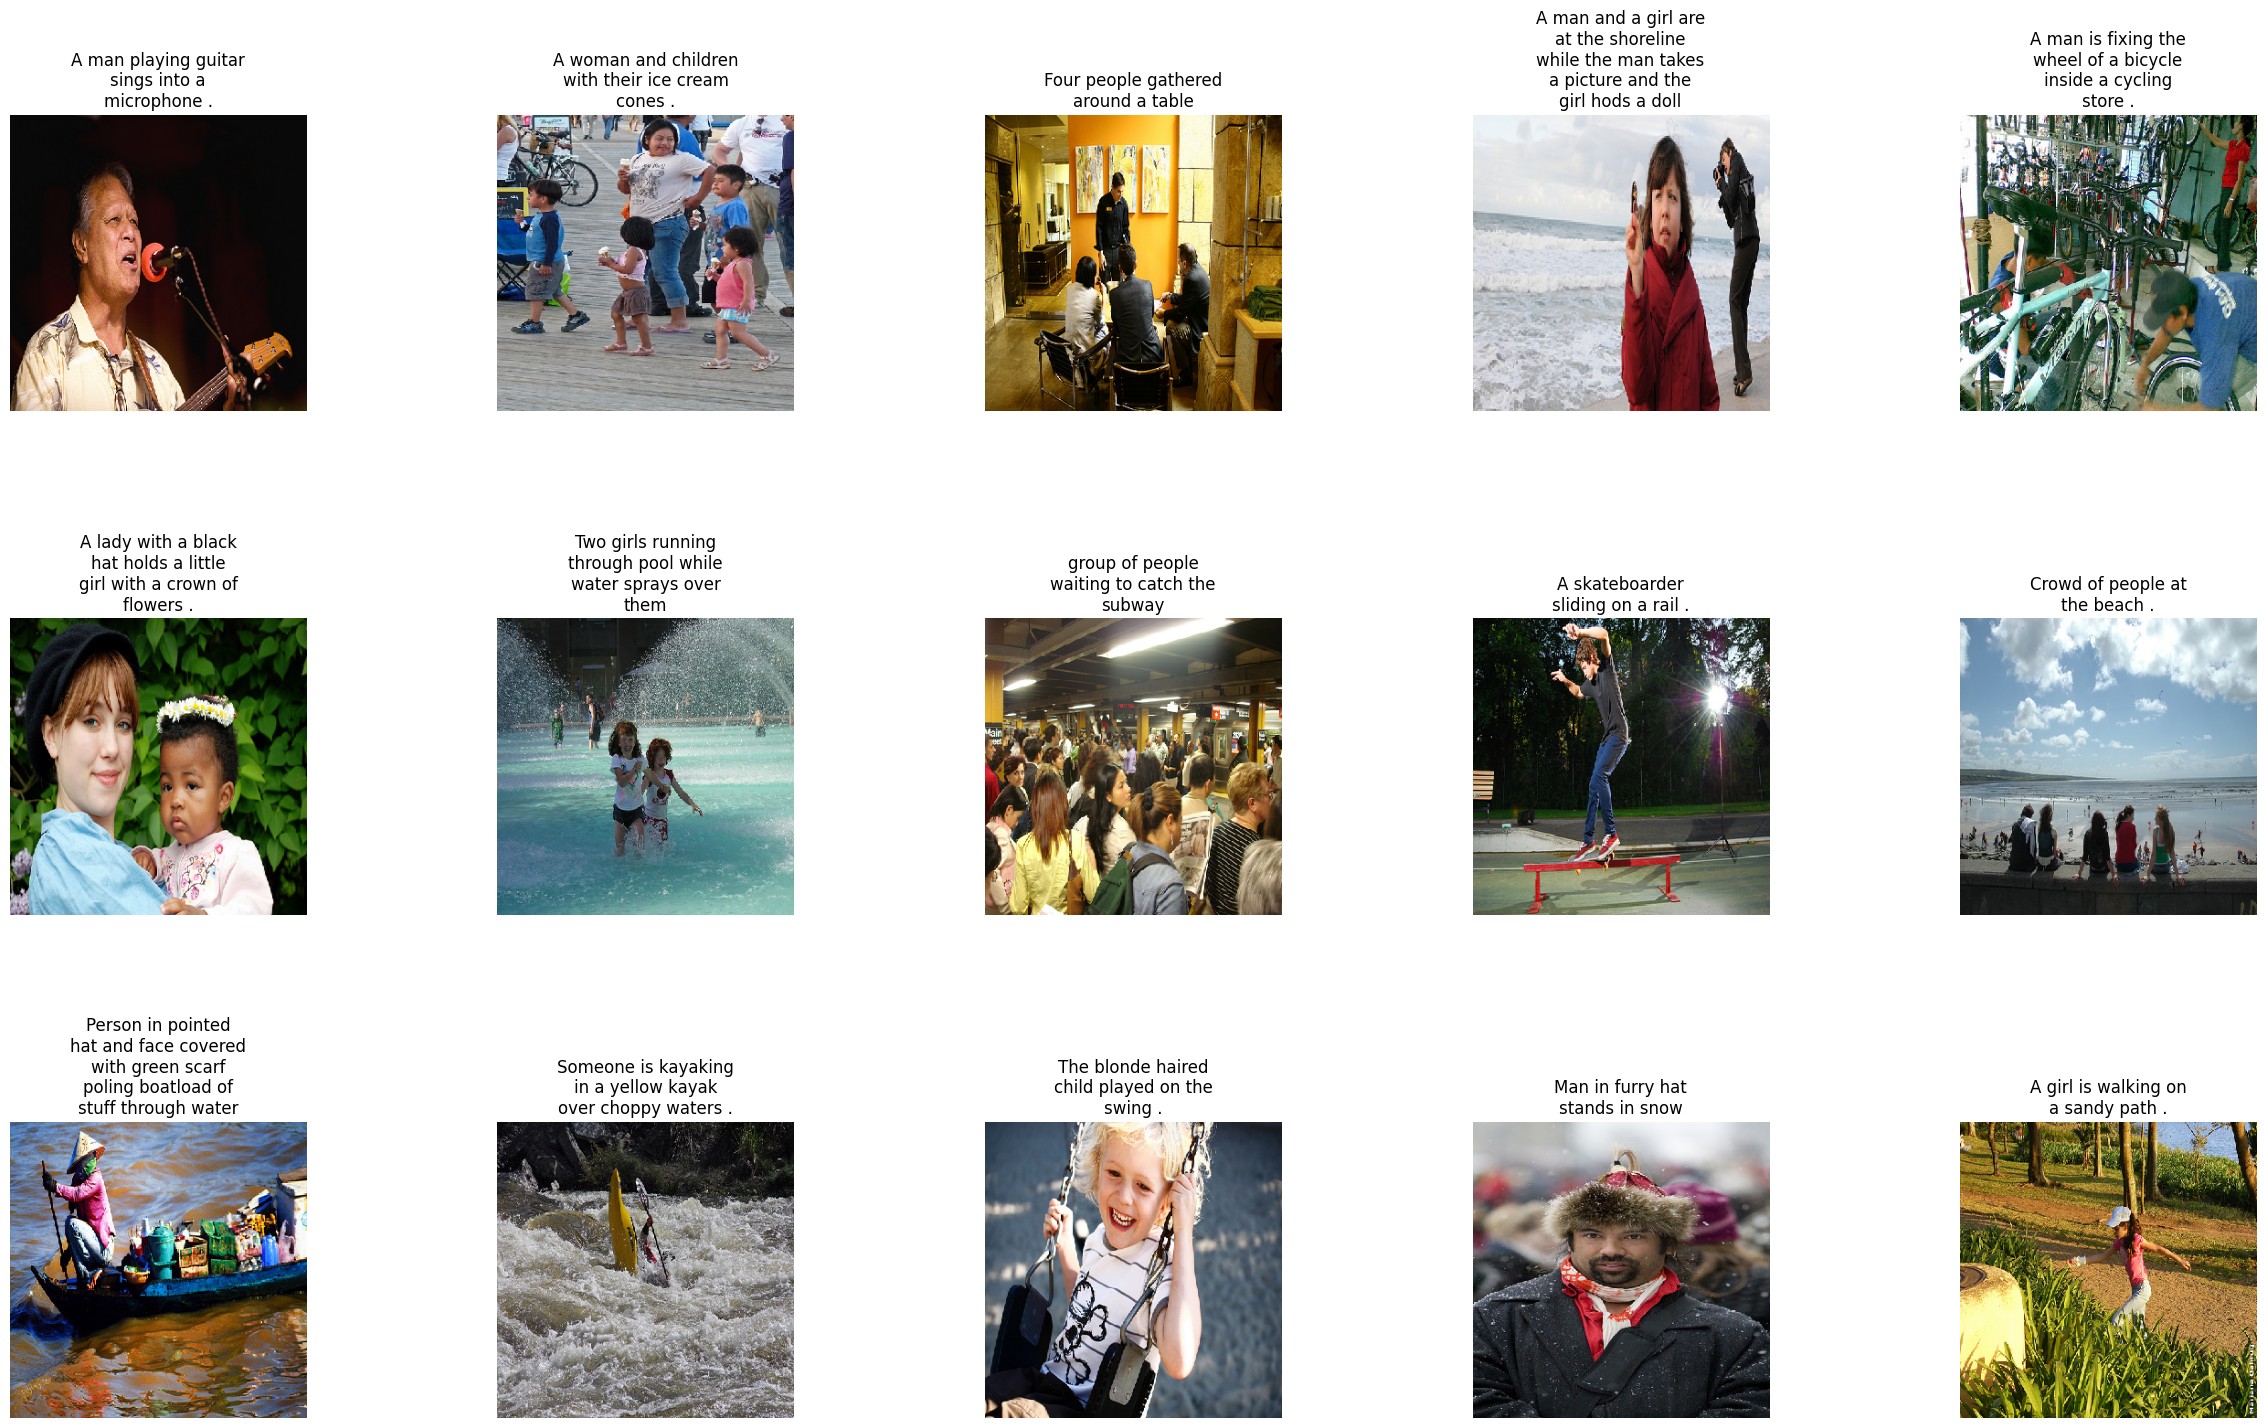

In [13]:
display_image(data.sample(15))

In [14]:
data

image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                 caption  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451           A man is rock climbing high in the air .  
40452  A person in a red shirt climbing up a rock fac...  
40453                    A rock climber in a red shirt .  
40454  A rock climber practices on a rock climbing wa...  

[40455 rows x 2 columns]

# Caption Text Preprocessing Steps
Convert sentences into lowercase

Remove special characters and numbers present in the text
Remove extra spaces
Remove single characters
Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

In [ ]:
def text_preprocessing(data):
    data['caption']=data['caption'].apply(lambda x:x.lower())
    data['caption']=data['caption'].apply(lambda x:x.replace("[^A-Za-z]",""))
    data['caption'] =data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] =data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] ="startseq "+data['caption']+" endseq"
    return data
    

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15460\4270276636.py:4: SyntaxWarning: invalid escape sequence '\s'
  data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))


# Preprocessed Text

In [17]:
data =text_preprocessing(data)
captions =data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size=len(tokenizer.word_index) + 1

max_length=max([len(caption.split()) for caption in captions])

images=data['image'].unique().tolist()
nimagea=len(images)

split_index=round(0.85*nimagea)
train_images=images[:split_index]
val_images=images[split_index:]

train=data[data['image'].isin(train_images)]
test=data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[10]])




[[1, 39, 18, 163, 3, 605, 105, 3, 47, 11, 593, 1190, 9, 59, 219, 3, 975, 2]]

In [28]:

#Tokenizer() creates a tool that converts words → numbers.

#fit_on_texts(captions) scans all captions and builds the vocabulary.
# tokenizer.word_index is a dictionary like: {"dog": 1, "cat": 2, "a": 3, ...}
# Maximum caption length -> "a man riding a brown horse" → length = 6 words

# Get all unique image names What it means:

#Dataset has many rows; same image appears multiple times (1 image → many captions).

#unique() removes duplicates.

#nimagea = total number of distinct images.

# 5️⃣ Train/Validation split
#What it means:

#85% images → training

#15% images → validation/testing

#Split is image-based, not caption-base


In [36]:
from tqdm import tqdm 
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}

for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [32:51<00:00,  4.10it/s]  


# Data Generation

Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise

The inputs will be the image embeddings and their corresonding caption text embeddings for the training process

The text embeddings are passed word by word for the caption generation during inference time




In [37]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [38]:
train_generator[0]

((array([[7.8687954e-05, 7.3524070e-04, 1.1395994e-03, ..., 5.6523442e-01,
          2.2903764e-01, 6.9639963e-01],
         [7.8687954e-05, 7.3524070e-04, 1.1395994e-03, ..., 5.6523442e-01,
          2.2903764e-01, 6.9639963e-01],
         [7.8687954e-05, 7.3524070e-04, 1.1395994e-03, ..., 5.6523442e-01,
          2.2903764e-01, 6.9639963e-01],
         ...,
         [1.9476049e-04, 7.0213008e-04, 1.4947485e-03, ..., 2.7233645e-02,
          5.5759478e-01, 3.8916609e-01],
         [1.9476049e-04, 7.0213008e-04, 1.4947485e-03, ..., 2.7233645e-02,
          5.5759478e-01, 3.8916609e-01],
         [1.9476049e-04, 7.0213008e-04, 1.4947485e-03, ..., 2.7233645e-02,
          5.5759478e-01, 3.8916609e-01]], shape=(3543, 1920), dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   1],
         [  0,   0,   0, ...,   0,   1,  42],
         [  0,   0,   0, ...,   1,  42,   3],
         ...,
         [  0,   0,   0, ...,  10,  76,  49],
         [  0,   0,   0, ...,  76,  49,   4],
         

# Modeling
The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network
The LSTM network starts generating words after each input thus forming a sentence at the end

In [41]:
from tensorflow.keras.utils import plot_model

input1=Input(shape=(1920,))
input2=Input(shape=(max_length,))


img_features = Dense(256, activation='relu')(input1)
img_features_reshaped =Reshape((1, 256), input_shape=(256,))(img_features)
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

from tensorflow.keras.callbacks import ModelCheckpoint


# Define the model checkpoint
model_name = "model.keras" 

checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)


history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])





C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\reshaping\reshape.py:38: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - loss: 5.6977
Epoch 1: val_loss improved from None to 4.28861, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 391s 716ms/step - loss: 5.1015 - val_loss: 4.2886 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 4.3396
Epoch 2: val_loss improved from 4.28861 to 3.97369, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 2891s 5s/step - loss: 4.2765 - val_loss: 3.9737 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - loss: 4.0274
Epoch 3: val_loss improved from 3.97369 to 3.83225, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 454s 845ms/step - loss: 4.0055 - val_loss: 3.8323 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - loss: 3.8567
Epoch 4: val_loss improved from 3.83225 to 3.74404, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 417s 776ms/step - loss: 3.8386 - val_loss: 3.7440 - learning_rate: 0.0010


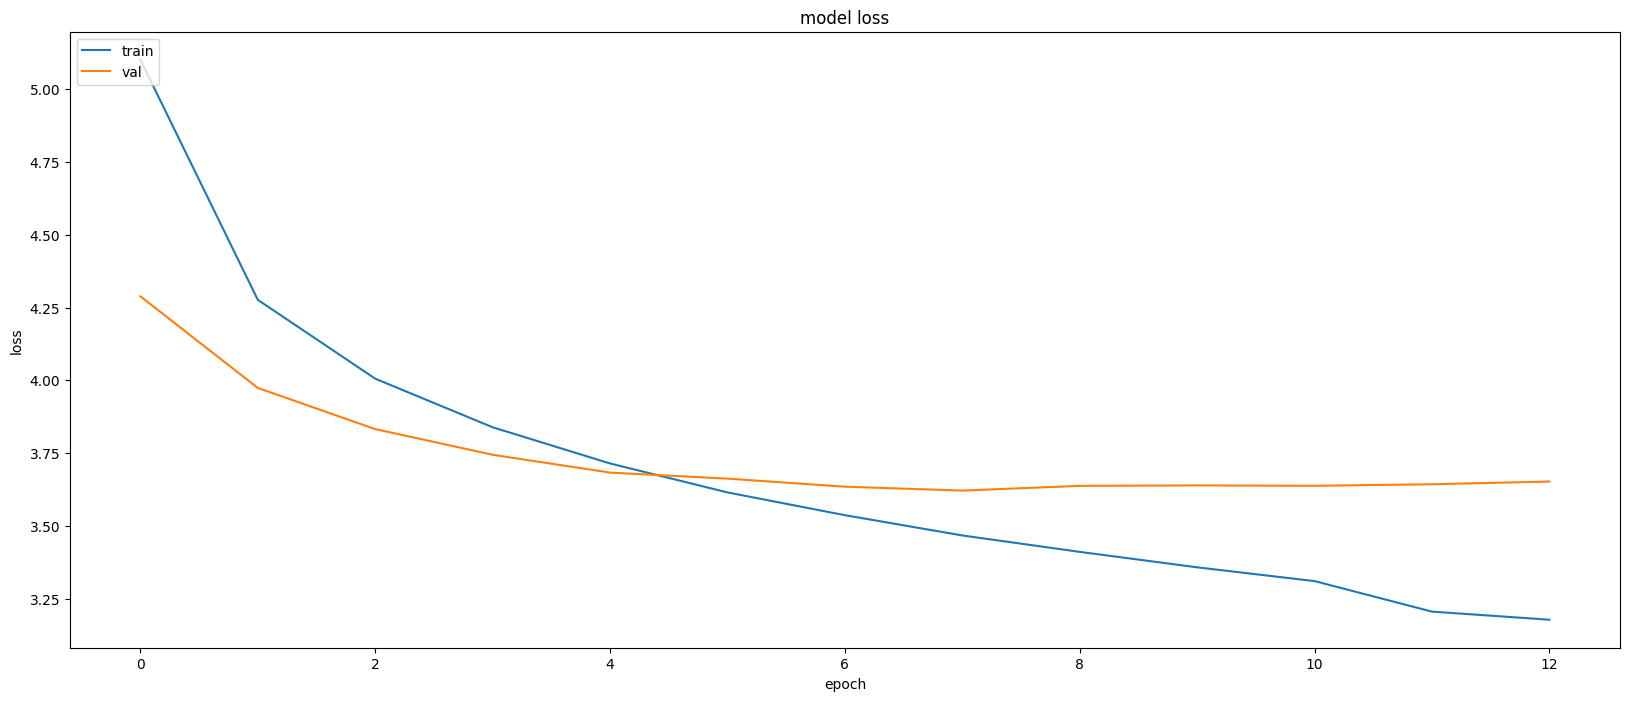

In [42]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
pickle.dump(fe,open('feature_extractor.pkl','wb'))

fe.save("feature_extractor.keras")


In [48]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features
    
    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')

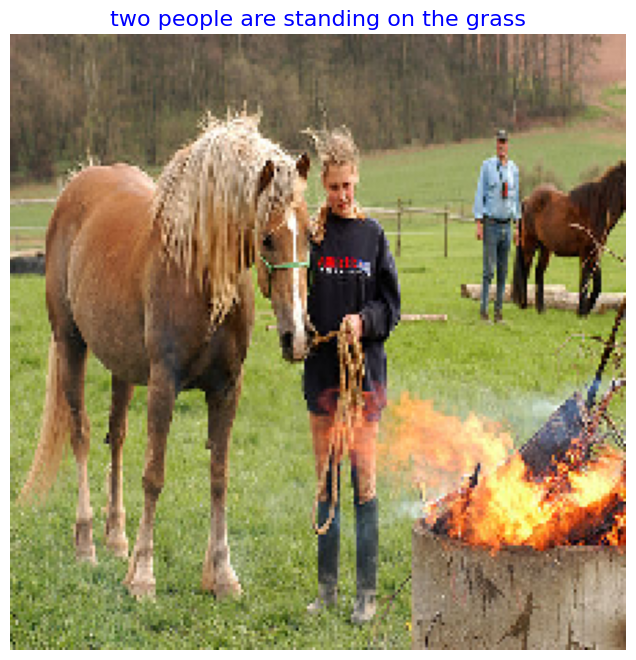

In [49]:
# Example usage
image_path = r"C:\Users\Lenovo\OneDrive\Documents\Data set\Image Caption\Images\10815824_2997e03d76.jpg" 
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

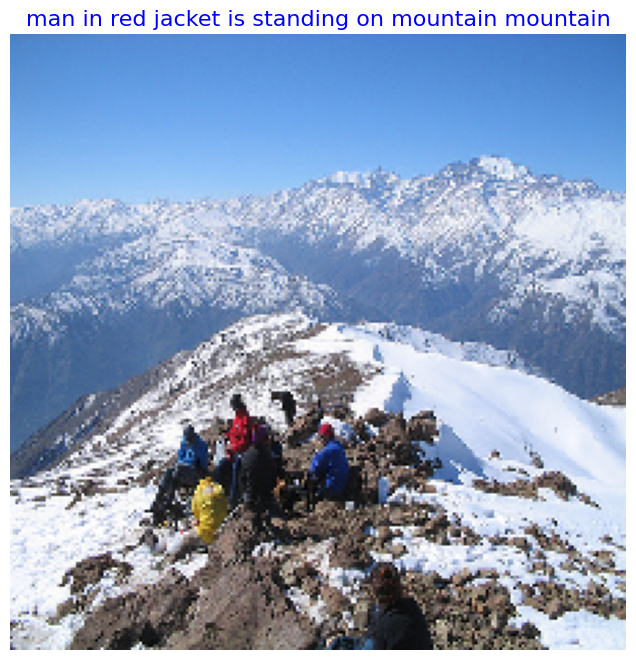

In [ ]:
image_path = r"C:\Users\Lenovo\OneDrive\Documents\Data set\Image Caption\Images\57417274_d55d34e93e.jpg" # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)


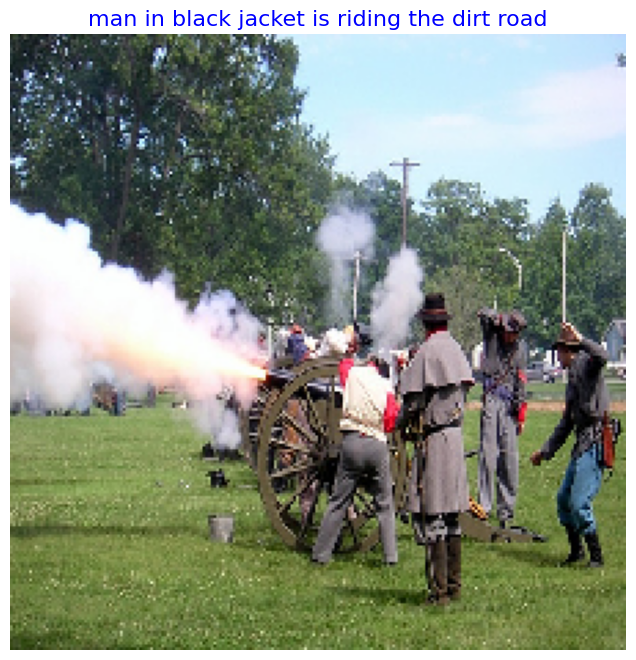

In [51]:
image_path =r"C:\Users\Lenovo\OneDrive\Documents\Data set\Image Caption\Images\61209225_8512e1dad5.jpg" # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)
